# Aspect ratio study

This section demonstrates a simple trade study for the example airplane using wing loading, power loading, aspect ratio, and maximum takeoff weight (MTOW). The goal of the study is to determine a value of aspect ratio that will yield the lowest MTOW. The aspect ratio is set to 7, 8, 9, 10, 11, and 12. The wing loading is varied from 30 $\text{lbs}/\text{ft}^2$ to 60 $\text{lbs}/\text{ft}^2$, while the power loading is varied from 6 lbs/hp to 12 lbs/hp. The MTOW and performance constraints are evaluated using the functions defined in [code setup section](setup.md). Below code block imports required packages and defines required performance metrics:

In [43]:
import nbimporter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mtow import compute_takeoff_weight
from constraint import compute_takeoff_groundroll, compute_landing_groundroll, compute_climb_gradient

max_ground_roll = 1500 # ft
min_oei_cgr = 0.015

Below code defines a function to create a plot of MTOW contours within a range of wing and power loading, along with highlighting a feasible region:

In [44]:
def plot_trade_study(A):
    """
        Function to create a trade study plot for a given A
    """

    num_pts = 20 # 80
    wing_loading = np.linspace(30, 60, num_pts) # lbs/sq ft
    power_loading = np.linspace(6, 12, num_pts) # lbs/hp

    X, Y = np.meshgrid(wing_loading, power_loading) # create a grid of (W/S,W/P) for evaluations

    mtow = np.zeros_like(X) # empty MTOW array
    takeoff_req = np.zeros_like(X) # empty TO array
    landing_req = np.zeros_like(X) # empty L array
    cgr_req = np.zeros_like(X) # empty cgr array
    cruise_speed_req = np.zeros_like(X) # empty array
    fuel_req = np.zeros_like(X) # fuel

    # Compute MTOW for each grid point
    for i in range(num_pts):
        for j in range(num_pts):

            WS = X[i,j]
            WP = Y[i,j]

            mtow[i,j], final_parameters = compute_takeoff_weight(WS, WP, A) # lbs
            final_parameters.MTOW = mtow[i,j]

            takeoff_req[i,j] = compute_takeoff_groundroll(final_parameters) - max_ground_roll
            landing_req[i,j] = compute_landing_groundroll(final_parameters) - max_ground_roll
            cgr_req[i,j] = min_oei_cgr - compute_climb_gradient(final_parameters)
            cruise_speed_req[i,j] = final_parameters.avg_cruise_power - final_parameters.P_cruise
            fuel_req[i,j] = final_parameters.fuel_weight / final_parameters.avgas_density - final_parameters.fuel_tank_volume

    # Plotting
    # levels = np.array([4600, 5000, 5400, 6000, 6600])
    levels = np.array([5600, 6000, 6500, 7400])
    fs = 11
    fig, ax = plt.subplots(figsize=(8,6))

    # MTOW contours
    cp = ax.contour(X, Y, mtow, levels=levels, colors="k", alpha=0.5)
    ax.clabel(cp, cp.levels, fontsize=fs, fmt=lambda x: f'W = {x:.0f} lbs')

    # TO constraints
    ax.contour(X, Y, takeoff_req, colors="r", levels=[0])
    mpl.rcParams['hatch.color'] = "r"
    ax.contourf(X, Y, takeoff_req, levels=[0, 50], colors='none', hatches=['//'])

    # L constraints
    ax.contour(X, Y, landing_req, colors="c", levels=[0])
    mpl.rcParams['hatch.color'] = "c"
    ax.contourf(X, Y, landing_req, levels=[0, 50], colors='none', hatches=['//'])

    # OEI constraints
    ax.contour(X, Y, cgr_req, colors="g", levels=[0])
    mpl.rcParams['hatch.color'] = "g"
    ax.contourf(X, Y, cgr_req, levels=[0, 0.003], colors='none', hatches=['//'])

    # Cruise speed
    ax.contour(X, Y, cruise_speed_req, colors="b", levels=[0])
    mpl.rcParams['hatch.color'] = "b"
    ax.contourf(X, Y, cruise_speed_req, levels=[0, 15], colors='none', hatches=['//'])

    # Fuel
    ax.contour(X, Y, fuel_req, colors="m", levels=[0])
    mpl.rcParams['hatch.color'] = "m"
    ax.contourf(X, Y, fuel_req, levels=[0, 7], colors='none', hatches=['//'])

    # Feasible region
    feasbile_region = np.logical_and.reduce([takeoff_req <= 0, landing_req <= 0, cgr_req <= 0, cruise_speed_req <= 0, fuel_req <= 0])
    ax.contourf(wing_loading, power_loading, feasbile_region, colors="r", levels=[0.5,1], alpha=0.4)

    # Asthetics
    ax.set_xlabel("Wing Loading ($W/S$) [lbs/$ft^2$]", fontsize=fs)
    ax.set_ylabel("Power Loading ($W/P$) [lbs/hp]", fontsize=fs)
    ax.set_title(f"Aspect ratio: {A}", fontsize=fs+1)
    ax.tick_params(axis='both', labelsize=fs-0.5)
    ax.annotate("Cruise speed\nof 200 kts", (34,8.0), color='b', fontsize=fs, va="center", ha="center")
    ax.annotate("Takeoff roll < 1500 ft", (50,10), color='r', fontsize=fs, va="center", ha="left")
    ax.annotate("OEI", (32,10.8), color='g', fontsize=fs, va="center", ha="left")
    ax.annotate("Wing fuel Volume", (47,11.5), color='m', fontsize=fs, va="center", ha="center")

    return ax

# Initialize empty array
A = np.array([7, 8, 9, 10, 11])
best_wing_loading = np.zeros(5) # lbs/sq ft
best_power_loading = np.zeros(5) # lbs/hp

Below code blocks create MTOW contours and overlays performance requirement lines for the selected range of aspect ratio values:

> __NOTE__: The landing ground roll requirement is satisfied for all the $A$ values. The wing fuel volume constraint refers to the maximum fuel volume that can be stored in the wings. Since the $A$ changes the wing planform, it is important to include this constraint to ensure that the final selected design can store enough fuel for the design mission.

## A = 7

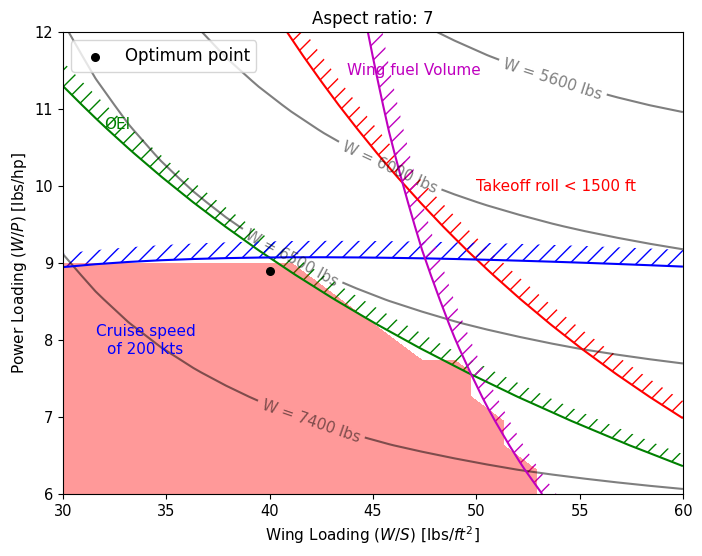

In [45]:
idx = 0 # index of the array
best_wing_loading[idx] = 40 # lbs/sq ft
best_power_loading[idx] = 8.9 # lbs/hp

ax = plot_trade_study(A[idx])
ax.scatter(best_wing_loading[idx], best_power_loading[idx], color="k", s=30, label="Optimum point")
_ = ax.legend(fontsize=12)

## A = 8

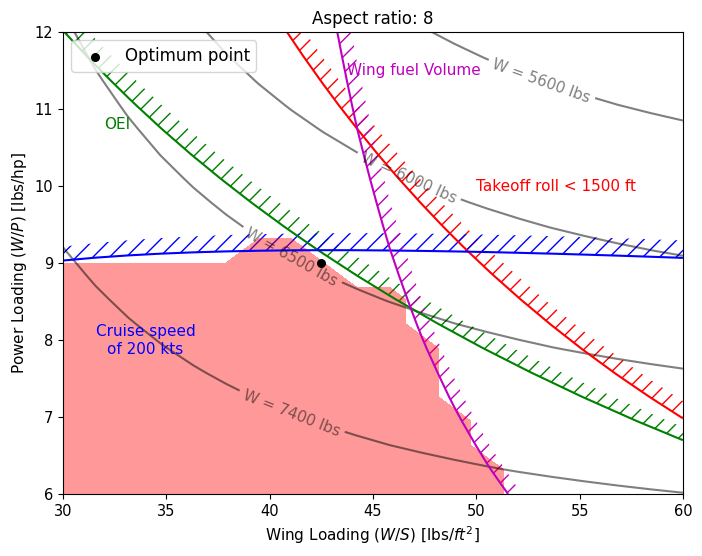

In [46]:
idx = 1 # index of the array
best_wing_loading[idx] = 42.5 # lbs/sq ft
best_power_loading[idx] = 9.0 # lbs/hp

ax = plot_trade_study(A[idx])
ax.scatter(best_wing_loading[idx], best_power_loading[idx], color="k", s=30, label="Optimum point")
_ = ax.legend(fontsize=12)

## A = 9

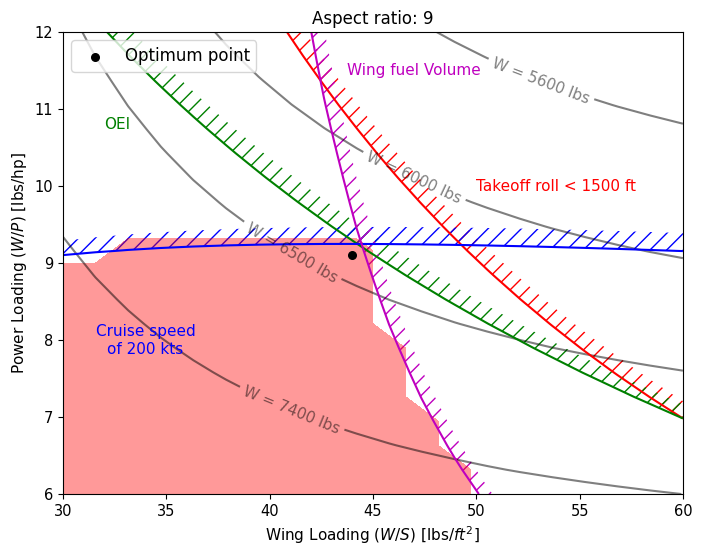

In [47]:
idx = 2 # index of the array
best_wing_loading[idx] = 44 # lbs/sq ft
best_power_loading[idx] = 9.1 # lbs/hp

ax = plot_trade_study(A[idx])
ax.scatter(best_wing_loading[idx], best_power_loading[idx], color="k", s=30, label="Optimum point")
_ = ax.legend(fontsize=12)

## A = 10

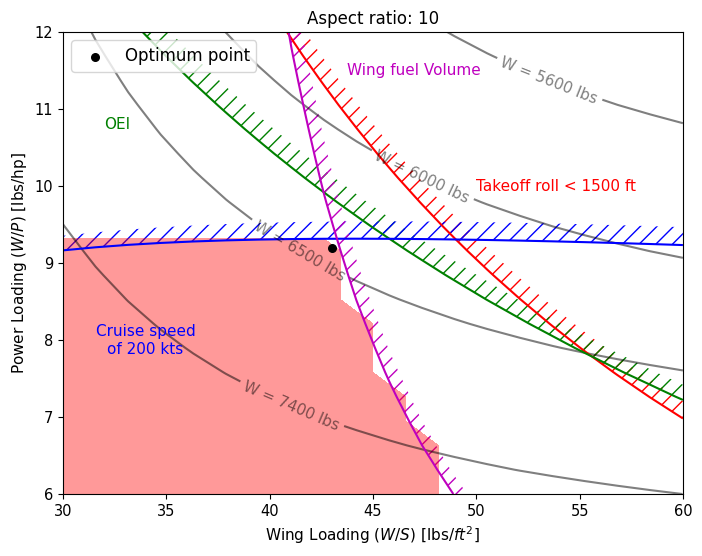

In [48]:
idx = 3 # index of the array
best_wing_loading[idx] = 43 # lbs/sq ft
best_power_loading[idx] = 9.2 # lbs/hp

ax = plot_trade_study(A[idx])
ax.scatter(best_wing_loading[idx], best_power_loading[idx], color="k", s=30, label="Optimum point")
_ = ax.legend(fontsize=12)

## A = 11

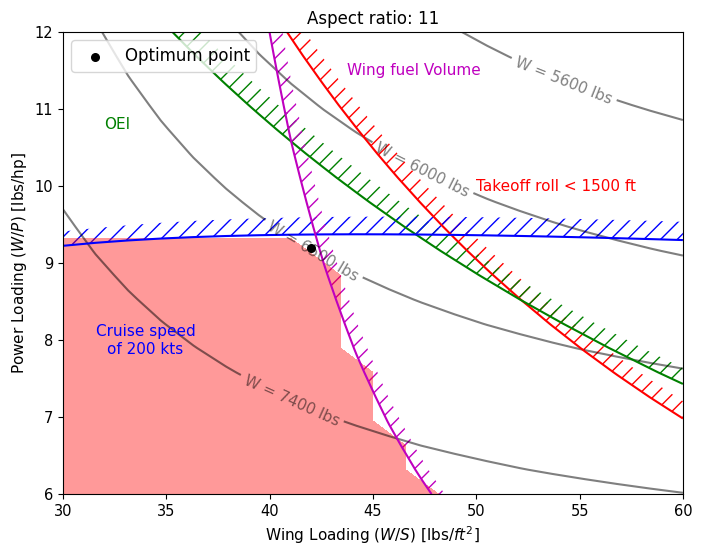

In [49]:
idx = 4 # index of the array
best_wing_loading[idx] = 42 # lbs/sq ft
best_power_loading[idx] = 9.2 # lbs/hp

ax = plot_trade_study(A[idx])
ax.scatter(best_wing_loading[idx], best_power_loading[idx], color="k", s=30, label="Optimum point")
_ = ax.legend(fontsize=12)

Based on the above graph, it can be seen that cruise speed, OEI climb gradient, and wing fuel volume are the driving constraints for the design. Below code block plots the best MTOW as the aspect ratio is varied:

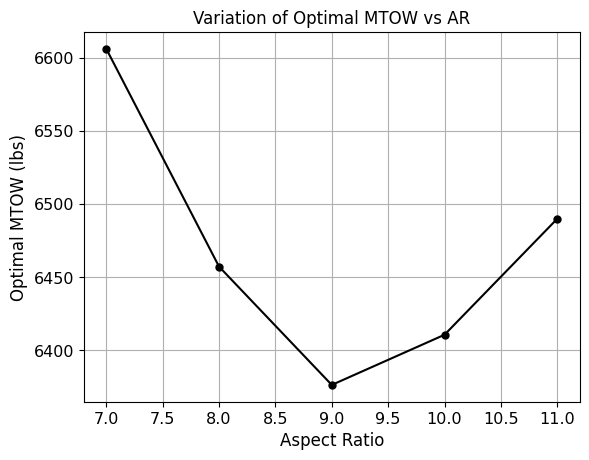

In [50]:
best_mtow = []

# Compute the best MTOW for a given (WS,WP)
for WS, WP, AR in zip(best_wing_loading, best_power_loading, A):
    mtow, _ = compute_takeoff_weight(WS, WP, AR)
    best_mtow.append(mtow)

# Ploting
fs = 12
fig, ax = plt.subplots()
ax.plot(A, best_mtow, "k-", marker=".", markersize=10)
ax.set_xlabel("Aspect Ratio", fontsize=fs)
ax.set_ylabel("Optimal MTOW (lbs)", fontsize=fs)
ax.set_title("Variation of Optimal MTOW vs AR", fontsize=fs)
ax.tick_params(axis='both', labelsize=fs-0.5)
ax.grid()

Based on the above plot, the aspect ratio of 9 yileds the lowest weight for the example airplane. Note that the maxmium wing fuel volume is one of the driving the constraints along with cruise speed. Below code block prints some major quantities for the final selected airplane:

In [51]:
MTOW, aircraft = compute_takeoff_weight(best_wing_loading[2], best_power_loading[2], A[2])

print("Major parameters for selected airplane:")
print(f"Maximum takeoff weight: {MTOW:.0f} lbs")
print(f"Empty weight: {aircraft.empty_weight:.0f} lbs")
print(f"Fuel weight: {aircraft.fuel_weight:.0f} lbs")
print(f"Maximum takeoff power: {aircraft.P_takeoff:.0f} hp")
print(f"Aspect ratio: {aircraft.A:.0f}")
print(f"Wing surface area: {aircraft.S:.0f} sq ft")
print(f"Wing span: {aircraft.b:.0f} ft")

Major parameters for selected airplane:
Maximum takeoff weight: 6376 lbs
Empty weight: 3449 lbs
Fuel weight: 1727 lbs
Maximum takeoff power: 701 hp
Aspect ratio: 9
Wing surface area: 145 sq ft
Wing span: 36 ft


This concludes the simple trade study example for the airplane. Similar studies can be performed for determining thickness ratio, taper ratio, etc. Note that further analysis (such as aerodynamics, high lift devices and stability) should be performed to ensure that the design is viable.